<a href="https://colab.research.google.com/github/lallapalooza91/APS360-Final-Project/blob/main/Lab3_Gesture_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 3: Gesture Recognition using Convolutional Neural Networks

In this lab you will train a convolutional neural network to make classifications on different hand gestures. By the end of the lab, you should be able to:

1. Load and split data for training, validation and testing
2. Train a Convolutional Neural Network
3. Apply transfer learning to improve your model

Note that for this lab we will not be providing you with any starter code. You should be able to take the code used in previous labs, tutorials and lectures and modify it accordingly to complete the tasks outlined below.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up
from parts 1-5. You can produce a PDF of your Google Colab file by
going to **File > Print** and then save as PDF. The Colab instructions
has more information. Make sure to review the PDF submission to ensure that your answers are easy to read. Make sure that your text is not cut off at the margins.

**Do not submit any other files produced by your code.**

Include a link to your colab file in your submission.

Please use Google Colab to complete this assignment. If you want to use Jupyter Notebook, please complete the assignment and upload your Jupyter Notebook file to Google Colab for submission.

## Colab Link

Include a link to your colab file here

Colab Link: https://colab.research.google.com/drive/114vCRj4NOQdzBHizKrhFEIb_X-nZeUnr?usp=sharing

In [ ]:
%%shell
jupyter nbconvert --to html "/content/Lab3_Gesture_Recognition (1).ipynb"

## Dataset

American Sign Language (ASL) is a complete, complex language that employs signs made by moving the
hands combined with facial expressions and postures of the body. It is the primary language of many
North Americans who are deaf and is one of several communication options used by people who are deaf or
hard-of-hearing. The hand gestures representing English alphabet are shown below. This lab focuses on classifying a subset
of these hand gesture images using convolutional neural networks. Specifically, given an image of a hand
showing one of the letters A-I, we want to detect which letter is being represented.

![alt text](https://www.disabled-world.com/pics/1/asl-alphabet.jpg)

## Part B. Building a CNN [50 pt]

For this lab, we are not going to give you any starter code. You will be writing a convolutional neural network
from scratch. You are welcome to use any code from previous labs, lectures and tutorials. You should also
write your own code.

You may use the PyTorch documentation freely. You might also find online tutorials helpful. However, all
code that you submit must be your own.

Make sure that your code is vectorized, and does not contain obvious inefficiencies (for example, unecessary
for loops, or unnecessary calls to unsqueeze()). Ensure enough comments are included in the code so that
your TA can understand what you are doing. It is your responsibility to show that you understand what you
write.

This is much more challenging and time-consuming than the previous labs. Make sure that you
give yourself plenty of time by starting early.

### 1. Data Loading and Splitting [5 pt]

Download the anonymized data provided on Quercus. To allow you to get a heads start on this project we will provide you with sample data from previous years. Split the data into training, validation, and test sets.

Note: Data splitting is not as trivial in this lab. We want our test set to closely resemble the setting in which
our model will be used. In particular, our test set should contain hands that are never seen in training!

Explain how you split the data, either by describing what you did, or by showing the code that you used.

Justify your choice of splitting strategy. How many training, validation, and test images do you have?

For loading the data, you can use plt.imread as in Lab 1, or any other method that you choose. You may find
torchvision.datasets.ImageFolder helpful. (see https://pytorch.org/docs/stable/torchvision/datasets.html?highlight=image%20folder#torchvision.datasets.ImageFolder
)

In [ ]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import os
import shutil
import matplotlib.pyplot as plt
import math as math
torch.manual_seed(1) # set the random seed

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# code to count the number of images in each data type
def count_files(path):
    count = 0
    for root, dirs, files in os.walk(path):
        count += len(files)
    return count

path = '/content/drive/MyDrive/lab3 dataset/train'
num_files = count_files(path)
print("Training images:", num_files)

path = '/content/drive/MyDrive/lab3 dataset/val'
num_files = count_files(path)
print("Validation images:", num_files)

path = '/content/drive/MyDrive/lab3 dataset/test'
num_files = count_files(path)
print("Testing images:", num_files)

Training images: 1633
Validation images: 292
Testing images: 294


I used a `73.6%:13.25%:13.15%` split for training:validation:test. Thus, I have `1633` training images, `294` testing images and `292` validation images.

I chose this split because it is important to have more training data so that the model can have enough data to learn. The validation and test datasets can be smaller as they are not what the model is learning on.

Each student submitted 27 images, 3 for each letter. To make sure no hands from the training dataset were repeated in testing, I made sure to only select images from the first `~61` students for the training dataset. Then, I selected images from the next `~11` students for the validation set, and then images from the final `~11` students for the testing dataset.

I was able to distinguish between images submitted by different students (and thus different hands) to ensure that no hands were repeated by looking at the pictures in the dataset, as well as their file names. For example, any picture with a file name of `"...I_3"` would signal the end of the pictures for that specific student.

However, to use the ImageFolder command, I had to re-create the classes for each letter inside each of the train, val and test folders. I did this using the `splitter` function that I wrote below.

In [ ]:
def splitter(data_type):

  # the path to my Google Drive where I uploaded the data that I split
  # using the method described above
  path = "/content/drive/MyDrive/lab3 dataset/" + data_type

  # loop over the letters A to I
  for i in range(ord('A'), ord('I') + 1):
    # Define the name of the new subdirectory
    new_dir_name = chr(i)
    # Define the path to the new subdirectory
    new_dir_path = os.path.join(path, new_dir_name)
    # Create the new subdirectory
    if not os.path.exists(new_dir_path):
      os.makedirs(new_dir_path)
    # Loop over the files in the folder
    for filename in os.listdir(path):
      # Check if the file is a JPEG image and contains the corresponing letter
      if filename.endswith(".jpg") and chr(i) in filename:
        # Move the file to the destination folder
        shutil.move(path + "/" + filename, path + "/" + chr(i))

In [ ]:
# split the train, val and test data back into classes
splitter("train")
splitter("val")
splitter("test")

Now, I could load the data using ImageFolder and the methods used in previous labs.

In [ ]:
# transforming the images to tensors of size 224X224
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Loading training dataset
train_data = ImageFolder(root="/content/drive/MyDrive/lab3 dataset/train", transform=transform)

# Loading validation dataset
val_data = ImageFolder(root="/content/drive/MyDrive/lab3 dataset/val", transform=transform)

# Loading testing dataset
test_data = ImageFolder(root="/content/drive/MyDrive/lab3 dataset/test", transform=transform)


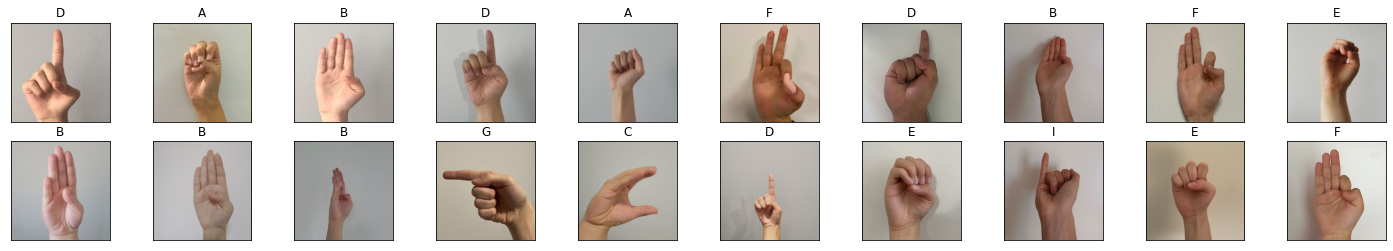

In [ ]:
# here I will visualize one batch of random data from the training set, as done in previous labs
train_loader = torch.utils.data.DataLoader(train_data, batch_size=20, shuffle = True)

letters = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']

for images, labels in train_loader:
  images = images.numpy() # convert images to numpy for display
  break

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(letters[labels[idx]])

### 2. Model Building and Sanity Checking [15 pt]

### Part (a) Convolutional Network - 5 pt

Build a convolutional neural network model that takes the (224x224 RGB) image as input, and predicts the gesture
letter. Your model should be a subclass of nn.Module. Explain your choice of neural network architecture: how
many layers did you choose? What types of layers did you use? Were they fully-connected or convolutional?
What about other decisions like pooling layers, activation functions, number of channels / hidden units?

**Answers:**

I used 3 convolutional layers followed by 2 fully-connected layers (one input, one output and one hidden).

I chose this architecture based on what was given to us in Tutorial 3a, as we are working with a similar set of data (images) in this lab. However, I added an extra convolutional layer as this dataset consists of hand gestures, and thus there are more complex features for the CNN to discover than in the tutorial, which analyzed the MNIST dataset. Additionally, since we are taking in the images as the input, and we must recognize complex features, there is a lot of training to be done. A lot of kernels will be needed to identify the features, and thus a complex network consisting of many convolutional and fully-connected layers is used.

I chose 2 max pooling layers, and used relu for all of the activation functions.

I chose output channels as follows:

`Convolutional layer 1: 5 outputs`

`Convolutional layer 2: 10 outputs`

`Convolutional layer 3: 25 outputs`

I increased the number of output channels going deeper into the network. I did this to increase the number of kernels, since as we go deeper into the CNN, there are more global, high-level features being analyzed, so more kernels are needed.

I also increased kernel size going deeper into the CNN as follows:

`Kernel 1 : 3x3`

`Kernel 2 : 5x5`

`Kernel 3 : 7x7`

I did this to decrease the output resolution, so we are looking at a larger area of the feature map each time and can thus better identify the higher-level features.

I chose 32 hidden units between the fully-connected layers. I picked this value based on positive results from previous labs.

In [ ]:
use_cuda = True

In [ ]:
# CNN architecture
class CNN(nn.Module):
    def __init__(self, ker1, ker2, ker3, pad):
        super(CNN, self).__init__()
        self.name = "CNN"
        # I used the kernel sizes as a hyperparameter, so it is passed into the contructor
        # the padding is also passed in to ensure that output size remains an integer
        # I used a 3-layer CNN with max pooling
        self.conv1 = nn.Conv2d(3, 5, ker1, stride = 1, padding = pad)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.pool2 = nn.MaxPool2d(2, 3)
        self.conv2 = nn.Conv2d(5, 10, ker2)
        self.conv3 = nn.Conv2d(10, 25, ker3)

        # output size computations
        c1_out = 224 - ker1 + (2*pad) + 1
        p1_out = ((c1_out - 2) / 2) + 1
        c2_out = p1_out - ker2 + 1
        p2_out = ((c2_out - 2) / 3) + 1
        c3_out = p2_out - ker3 + 1
        self.p3_out = int(((c3_out - 2) / 2) + 1)

        # i used 2 fully connected layers at the end of the convolutional layers
        self.fc1 = nn.Linear(25 * self.p3_out * self.p3_out, 32) # (flattened input, hidden units)
        self.fc2 = nn.Linear(32, 9) # (hidden units, classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool1(F.relu(self.conv3(x)))
        x = x.view(-1, 25 * self.p3_out * self.p3_out)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

### Part (b) Training Code - 5 pt

Write code that trains your neural network given some training data. Your training code should make it easy
to tweak the usual hyperparameters, like batch size, learning rate, and the model object itself. Make sure
that you are checkpointing your models from time to time (the frequency is up to you). Explain your choice
of loss function and optimizer.

**Answers**

I used the `Adam` optimizer since it offers adaptive learning rates. The learning rates scale to adapt to the different weights, instead of being constant for all weights, which in this case worked better than SGD (I verified this when overfitting to the small dataset).

I used Cross Entropy as the loss function firstly because in this lab we have to separate images into 9 classes (this ruled out binary cross entropy). Additionally, Cross Entropy works best for classification problems as it encourages models to output accurate probability distributions, penalizes the model more heavily for incorrect predictions, and can be efficiently optimized using gradient-based methods.

In [ ]:
# this function is used to save checkpoints
def get_model_name(name, batch_size, learning_rate, epoch, ker_increase):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    if (ker_increase == True):
      ker = 'increasing'
    else:
      ker = 'decreasing'

    path = "model_{0}_bs{1}_lr{2}_epoch{3}_{4}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch, ker)
    return path

In [ ]:
# get_accuracy function used in training and evaluating model performance
def get_accuracy(model, batch_size, data):
    correct = 0
    total = 0
    for imgs, labels in torch.utils.data.DataLoader(data, batch_size=batch_size):

        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        #############################################

        output = model(imgs)

        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [ ]:
# training function
def train(model, train_data, val_data, batch_size, num_epochs, learning_rate, ker_increase):
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)

    # creating a data loader for iteration
    data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle = True)

    # used cross entropy for loss function
    criterion = nn.CrossEntropyLoss()

    # used Adam optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    iters, losses, train_acc, val_acc = [], [], [], []
    train_acc = np.zeros(num_epochs)
    val_acc = np.zeros(num_epochs)

    # training
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        for imgs, labels in iter(data_loader):
            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            #############################################

            out = model(imgs)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch
            n += 1

        # save the current training information
        iters.append(n)
        losses.append(float(loss)/batch_size)             # compute *average* loss
        train_acc[epoch] = get_accuracy(model, batch_size, train_data) # compute training accuracy
        val_acc[epoch] = get_accuracy(model, batch_size, val_data)  # compute validation accuracy

        # Save the current model (checkpoint) to a file
        model_path = get_model_name(model.name, batch_size, learning_rate, epoch, ker_increase)
        torch.save(model.state_dict(), model_path)

        # printing
        print(("Epoch {}: Train acc: {}, Train loss: {} |"+
               "Validation acc: {}").format(
                   epoch + 1,
                   train_acc[epoch],
                   losses[epoch],
                   val_acc[epoch]))

    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

In [ ]:
!nvidia-smi

### Part (c) “Overfit” to a Small Dataset - 5 pt

One way to sanity check our neural network model and training code is to check whether the model is capable
of “overfitting” or “memorizing” a small dataset. A properly constructed CNN with correct training code
should be able to memorize the answers to a small number of images quickly.

Construct a small dataset (e.g. just the images that you have collected). Then show that your model and
training code is capable of memorizing the labels of this small data set.

With a large batch size (e.g. the entire small dataset) and learning rate that is not too high, You should be
able to obtain a 100% training accuracy on that small dataset relatively quickly (within 200 iterations).

In [ ]:
# transforming the images to tensors of size 224X224
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Loading the small dataset
small_data = ImageFolder(root="/content/drive/MyDrive/small dataset", transform=transform)

In [ ]:
# function to overfit to the data
def train_overfit(model, data, batch_size, num_epochs, learning_rate):
    data_loader = torch.utils.data.DataLoader(data, batch_size=batch_size)
    criterion = nn.CrossEntropyLoss()
    # using Adam optimizer instead of SGD
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        for imgs, labels in iter(data_loader):


            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            #############################################


            out = model(imgs)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch
            n += 1

        # save the current training information
        iters.append(n)
        losses.append(float(loss)/batch_size)             # compute *average* loss
        train_acc.append(get_accuracy(model, batch_size, small_data)) # compute training accuracy
        # printing
        print(("Epoch {}: Train acc: {}, Train loss: {}").format(
                   epoch + 1,
                   train_acc[epoch],
                   losses[epoch],
                   ))

    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))

In [ ]:
# creating the model
model = CNN(10, 5, 3, 0)
model.cuda()

# overfitting
train_overfit(model, small_data, batch_size = 27, num_epochs = 60, learning_rate = 0.001)

The model achieves an accuracy of 1.0 on the training data, showing that it has memorized the small dataset.

### 3. Hyperparameter Search [10 pt]

### Part (a) - 1 pt

List 3 hyperparameters that you think are most worth tuning. Choose at least one hyperparameter related to
the model architecture.

**Hyperparameters chosen for tuning:**

1. Kernel Size

2. Batch size

3. Number of fully connected layers (this one is related to model architecture)


### Part (b) - 5 pt

Tune the hyperparameters you listed in Part (a), trying as many values as you need to until you feel satisfied
that you are getting a good model. Plot the training curve of at least 4 different hyperparameter settings.

In [ ]:
# transforming the images to tensors of size 224X224
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Loading training dataset
train_data = ImageFolder(root="/content/drive/MyDrive/lab3 dataset/train", transform=transform)

# Loading validation dataset
val_data = ImageFolder(root="/content/drive/MyDrive/lab3 dataset/val", transform=transform)

**1. Kernel Size**

***i. Increasing kernel size:  3 -> 5 -> 7***

I will increase the kernel size as I go deeper into the model.

Epoch 1: Train acc: 0.1267605633802817, Train loss: 0.030936990465436662 |Validation acc: 0.11986301369863013
Epoch 2: Train acc: 0.3453766074709124, Train loss: 0.027336106981549944 |Validation acc: 0.386986301369863
Epoch 3: Train acc: 0.4709124311083895, Train loss: 0.02479262522288731 |Validation acc: 0.4726027397260274
Epoch 4: Train acc: 0.6044090630740968, Train loss: 0.018204106603349958 |Validation acc: 0.6027397260273972
Epoch 5: Train acc: 0.6215554194733619, Train loss: 0.01572764941624233 |Validation acc: 0.5787671232876712
Epoch 6: Train acc: 0.646050214329455, Train loss: 0.013045832089015415 |Validation acc: 0.5924657534246576
Epoch 7: Train acc: 0.6864666258420086, Train loss: 0.018134519032069616 |Validation acc: 0.6027397260273972
Epoch 8: Train acc: 0.6883037354562156, Train loss: 0.014069397108895439 |Validation acc: 0.613013698630137
Epoch 9: Train acc: 0.7317819963257808, Train loss: 0.017642973150525775 |Validation acc: 0.6883561643835616
Epoch 10: Train acc: 0.

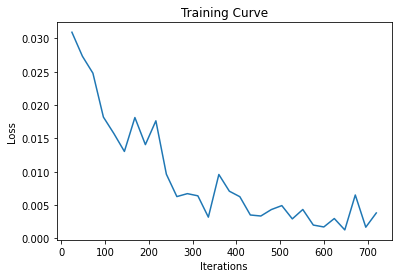

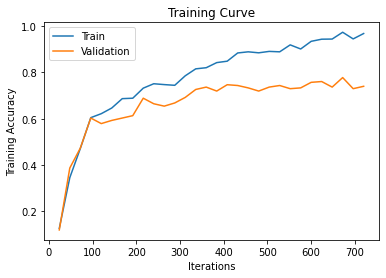

Final Training Accuracy: 0.9675443968156767
Final Validation Accuracy: 0.7397260273972602


In [ ]:
# recall CNN constructor takes (ker1, ker2, ker3, padding)
model = CNN(3, 5, 7, 0)
model.cuda()

train(model, train_data, val_data, batch_size=70, num_epochs = 30, learning_rate = 0.0005, ker_increase = True)

***ii. Decreasing kernel size:  7 -> 5 -> 3***

I will now do the opposite, decreasing the kernel size as I go deeper into the network.

Epoch 1: Train acc: 0.11083894672382119, Train loss: 0.031216723578316823 |Validation acc: 0.10273972602739725
Epoch 2: Train acc: 0.11267605633802817, Train loss: 0.03124164513179234 |Validation acc: 0.11301369863013698
Epoch 3: Train acc: 0.11267605633802817, Train loss: 0.03150794165475028 |Validation acc: 0.11301369863013698
Epoch 4: Train acc: 0.11083894672382119, Train loss: 0.0317000116620745 |Validation acc: 0.10273972602739725
Epoch 5: Train acc: 0.11267605633802817, Train loss: 0.031261931146894184 |Validation acc: 0.11301369863013698
Epoch 6: Train acc: 0.11206368646662584, Train loss: 0.03156498840876988 |Validation acc: 0.10616438356164383
Epoch 7: Train acc: 0.11696264543784446, Train loss: 0.03187351908002581 |Validation acc: 0.10616438356164383
Epoch 8: Train acc: 0.1769748928352725, Train loss: 0.02919658592769078 |Validation acc: 0.1678082191780822
Epoch 9: Train acc: 0.32578077158603796, Train loss: 0.030738833972385953 |Validation acc: 0.2910958904109589
Epoch 10: T

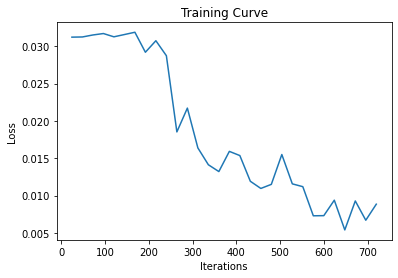

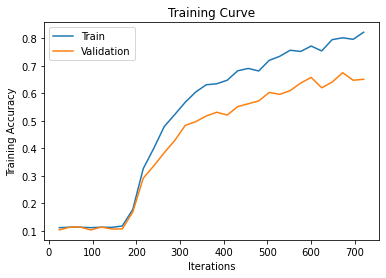

Final Training Accuracy: 0.8218003674219229
Final Validation Accuracy: 0.6506849315068494


In [ ]:
model = CNN(7, 5, 3, 0)
model.cuda()

train(model, train_data, val_data, batch_size=70, num_epochs = 30, learning_rate = 0.0005, ker_increase = False)

Increasing the kernel size as we go deeper into the network (seen in (i)) gave better accuracy, so I will use that going forward.

**2. Batch Size**

***i. Decreasing batch size to 50***

The batch size was previously 70, which is a bit high. I will decrease it to 50.

Epoch 1: Train acc: 0.10777709736680956, Train loss: 0.043863167762756346 |Validation acc: 0.1095890410958904
Epoch 2: Train acc: 0.21739130434782608, Train loss: 0.0405145788192749 |Validation acc: 0.25
Epoch 3: Train acc: 0.4188609920391917, Train loss: 0.035149359703063966 |Validation acc: 0.4486301369863014
Epoch 4: Train acc: 0.578689528475199, Train loss: 0.02393230438232422 |Validation acc: 0.5445205479452054
Epoch 5: Train acc: 0.6056338028169014, Train loss: 0.02466097354888916 |Validation acc: 0.5856164383561644
Epoch 6: Train acc: 0.7066748315982854, Train loss: 0.014114178419113159 |Validation acc: 0.6883561643835616
Epoch 7: Train acc: 0.7268830373545622, Train loss: 0.01679651975631714 |Validation acc: 0.6883561643835616
Epoch 8: Train acc: 0.7513778322106552, Train loss: 0.014041999578475952 |Validation acc: 0.6643835616438356
Epoch 9: Train acc: 0.7672994488671158, Train loss: 0.015414485931396485 |Validation acc: 0.7602739726027398
Epoch 10: Train acc: 0.80159216166564

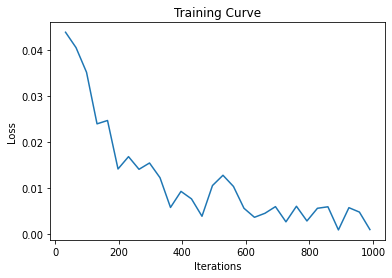

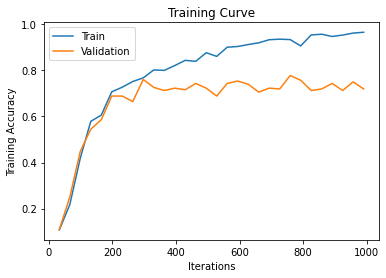

Final Training Accuracy: 0.9650949173300674
Final Validation Accuracy: 0.7191780821917808


In [ ]:
model = CNN(3, 5, 7, 0)
model.cuda()

train(model, train_data, val_data, batch_size=50, num_epochs = 30, learning_rate = 0.0005, ker_increase = True)

Decreasing the batch size increased the validation accuracy. I will decrease it further to see what it does.

**ii. Decreasing batch size to 30**

15
Epoch 1: Train acc: 0.2039191671769749, Train loss: 0.07185208797454834 |Validation acc: 0.1815068493150685
Epoch 2: Train acc: 0.2535211267605634, Train loss: 0.06459986368815104 |Validation acc: 0.22945205479452055
Epoch 3: Train acc: 0.44519289650949173, Train loss: 0.06093277931213379 |Validation acc: 0.4041095890410959
Epoch 4: Train acc: 0.5835884874464177, Train loss: 0.062444643179575605 |Validation acc: 0.5308219178082192
Epoch 5: Train acc: 0.6001224739742804, Train loss: 0.04277212619781494 |Validation acc: 0.5753424657534246
Epoch 6: Train acc: 0.6368646662584201, Train loss: 0.02944508989651998 |Validation acc: 0.6164383561643836
Epoch 7: Train acc: 0.7030006123698714, Train loss: 0.053901398181915285 |Validation acc: 0.6575342465753424
Epoch 8: Train acc: 0.7085119412124924, Train loss: 0.030614594618479412 |Validation acc: 0.6541095890410958
Epoch 9: Train acc: 0.7385180649112064, Train loss: 0.04573939243952433 |Validation acc: 0.6815068493150684
Epoch 10: Train acc:

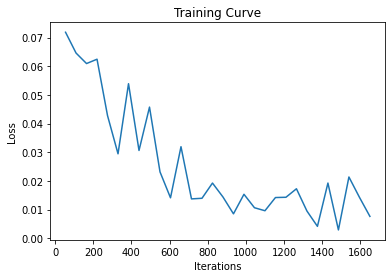

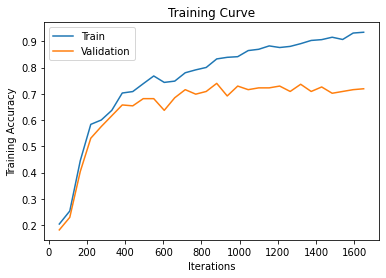

Final Training Accuracy: 0.934476423759951
Final Validation Accuracy: 0.7191780821917808


In [ ]:
model = CNN(3, 5, 7, 0)
model.cuda()

train(model, train_data, val_data, batch_size=30, num_epochs = 30, learning_rate = 0.0005, ker_increase = True)

The batch size of 50 gave the better result so I will use that going forward.

**3. Number of fully connected layers**

***i. Adding another hidden layer***

In [ ]:
# Defining a new CNN with an additional hidden layer of 70 units
class CNN_extra_hidden(nn.Module):
    def __init__(self, ker1, ker2, ker3, pad):
        super(CNN_extra_hidden, self).__init__()
        self.name = "CNN_extra_hidden_layer"
        self.conv1 = nn.Conv2d(3, 5, ker1, stride = 1, padding = pad) # (input channels, output channels, kernel size)
        self.pool1 = nn.MaxPool2d(2, 2) # (kernel size, stride)
        self.pool2 = nn.MaxPool2d(2, 3) # (kernel size, stride)
        self.conv2 = nn.Conv2d(5, 10, ker2) # (input channels, output channels, kernel size)
        self.conv3 = nn.Conv2d(10, 25, ker3) # (input channels, output channels, kernel size)
        # output size computations
        c1_out = 224 - ker1 + (2*pad) + 1
        p1_out = ((c1_out - 2) / 2) + 1
        c2_out = p1_out - ker2 + 1
        p2_out = ((c2_out - 2) / 3) + 1
        c3_out = p2_out - ker3 + 1
        self.p3_out = int(((c3_out - 2) / 2) + 1)
        self.fc1 = nn.Linear(25 * self.p3_out * self.p3_out, 70) # (flattened input, hidden units)
        ##### extra hidden layer  #########
        self.fc2 = nn.Linear(70, 32)
        self.fc3 = nn.Linear(32, 9) # (hidden units, classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool1(F.relu(self.conv3(x)))
        x = x.view(-1, 25 * self.p3_out * self.p3_out)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Epoch 1: Train acc: 0.11083894672382119, Train loss: 0.04415889263153076 |Validation acc: 0.10273972602739725
Epoch 2: Train acc: 0.1224739742804654, Train loss: 0.042961044311523436 |Validation acc: 0.1232876712328767
Epoch 3: Train acc: 0.33190447030006126, Train loss: 0.03846828460693359 |Validation acc: 0.363013698630137
Epoch 4: Train acc: 0.5505205143906919, Train loss: 0.025433139801025392 |Validation acc: 0.5445205479452054
Epoch 5: Train acc: 0.6325780771586038, Train loss: 0.02164858818054199 |Validation acc: 0.6198630136986302
Epoch 6: Train acc: 0.6582976117575016, Train loss: 0.016098451614379884 |Validation acc: 0.6027397260273972
Epoch 7: Train acc: 0.713410900183711, Train loss: 0.01597106337547302 |Validation acc: 0.6678082191780822
Epoch 8: Train acc: 0.7232088181261482, Train loss: 0.014958558082580566 |Validation acc: 0.684931506849315
Epoch 9: Train acc: 0.7587262706674831, Train loss: 0.01896480083465576 |Validation acc: 0.726027397260274
Epoch 10: Train acc: 0.78

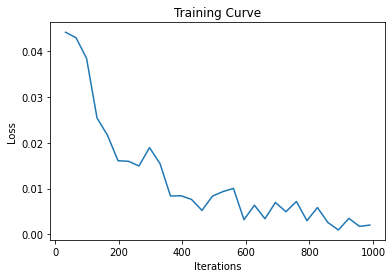

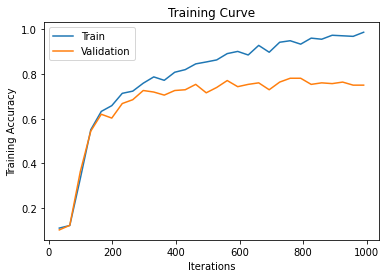

Final Training Accuracy: 0.9865278628291488
Final Validation Accuracy: 0.75


In [ ]:
model = CNN_extra_hidden(3, 5, 7, 0)
model.cuda()

train(model, train_data, val_data, batch_size=50, num_epochs = 30, learning_rate = 0.0005, ker_increase = True)

This model performs the best on the validation data. I will use it in the following parts on the test data.

### Part (c) - 2 pt
Choose the best model out of all the ones that you have trained. Justify your choice.

**Answer:**

I picked the model checkpoint at `Epoch 24` from when I added an additional fully connected layer (see Part (b)(3)(i)). I chose  this model checkpoint because it gave the highest validation accuracy: `0.7808219178082192`.

In [ ]:
model = CNN_extra_hidden(3, 5, 7, 0)
model.cuda()
model_path = get_model_name(model.name, batch_size=50, learning_rate=0.0005, epoch=23, ker_increase = True)
state = torch.load(model_path)
model.load_state_dict(state)

<All keys matched successfully>

### Part (d) - 2 pt
Report the test accuracy of your best model. You should only do this step once and prior to this step you should have only used the training and validation data.

In [ ]:
# transforming the images to tensors of size 224X224
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Loading testing dataset
test_data = ImageFolder(root="/content/drive/MyDrive/lab3 dataset/test", transform=transform)

# getting the test accuracy
test_acc = get_accuracy(model, batch_size = 50, data = test_data)
print("Test accuracy is: {}".format(test_acc))

Test accuracy is: 0.7619047619047619


The best model achieved a test accuracy of `0.7619047619047619`.

### 4. Transfer Learning [15 pt]
For many image classification tasks, it is generally not a good idea to train a very large deep neural network
model from scratch due to the enormous compute requirements and lack of sufficient amounts of training
data.

One of the better options is to try using an existing model that performs a similar task to the one you need
to solve. This method of utilizing a pre-trained network for other similar tasks is broadly termed **Transfer
Learning**. In this assignment, we will use Transfer Learning to extract features from the hand gesture
images. Then, train a smaller network to use these features as input and classify the hand gestures.

As you have learned from the CNN lecture, convolution layers extract various features from the images which
get utilized by the fully connected layers for correct classification. AlexNet architecture played a pivotal
role in establishing Deep Neural Nets as a go-to tool for image classification problems and we will use an
ImageNet pre-trained AlexNet model to extract features in this assignment.

### Part (a) - 5 pt
Here is the code to load the AlexNet network, with pretrained weights. When you first run the code, PyTorch
will download the pretrained weights from the internet.

In [ ]:
import torchvision.models
alexnet = torchvision.models.alexnet(pretrained=True)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

The alexnet model is split up into two components: *alexnet.features* and *alexnet.classifier*. The
first neural network component, *alexnet.features*, is used to compute convolutional features, which are
taken as input in *alexnet.classifier*.

The neural network alexnet.features expects an image tensor of shape Nx3x224x224 as input and it will
output a tensor of shape Nx256x6x6 . (N = batch size).

Compute the AlexNet features for each of your training, validation, and test data.

Save the computed features. You will be using these features as input to your neural network in Part
(b), and you do not want to re-compute the features every time. Instead, run *alexnet.features* once for
each image, and save the result.

In [ ]:
# SAVING THE COMPUTED FEATURES
# This block doesn't need to be run more than once (I've already run it once and everything is saved)
# transforming the images to tensors of size 224X224
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Loading training dataset
# i define the batch size as 1 to make it easy to label
train_data = ImageFolder(root="/content/drive/MyDrive/lab3 dataset/train", transform=transform)
train_loader =  torch.utils.data.DataLoader(train_data, batch_size=1, shuffle = True)

# Loading val dataset
val_data = ImageFolder(root="/content/drive/MyDrive/lab3 dataset/val", transform=transform)
val_loader =  torch.utils.data.DataLoader(val_data, batch_size=1, shuffle = True)

# Loading test dataset
test_data = ImageFolder(root="/content/drive/MyDrive/lab3 dataset/test", transform=transform)
test_loader =  torch.utils.data.DataLoader(test_data, batch_size=1, shuffle = True)

# defining paths to save the alexnet features
train_path = '/content/drive/MyDrive/alexnet data/train'
val_path ='/content/drive/MyDrive/alexnet data/val'
test_path = '/content/drive/MyDrive/alexnet data/test'

# defining the labels so that I can easily split the data for ImageFolder
letters = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']

# train data
# now need to precompute the features, and save them with their labels
n = 0
for img, label in train_loader:
  # compute the feature
  feature = alexnet.features(img)
  # convert feature to a tensor using code provided
  feature = torch.from_numpy(feature.detach().numpy()).squeeze(0)
  # make the subdirectories
  # Define the name of the new subdirectory
  new_dir_name = letters[label]
  # Define the path to the new subdirectory
  new_dir_path = os.path.join(train_path, new_dir_name)
  if not os.path.exists(new_dir_path):
    os.makedirs(new_dir_path)
  # now I need to put the feature tensor into the subdirectory
  torch.save(feature, os.path.join(new_dir_path, str(n) + '.tensor'))
  n += 1

# val data
n = 0
for img, label in val_loader:
  # compute the feature
  feature = alexnet.features(img)
  # convert feature to a tensor using code provided
  feature = torch.from_numpy(feature.detach().numpy()).squeeze(0)
  # make the subdirectories
  # Define the name of the new subdirectory
  new_dir_name = letters[label]
  # Define the path to the new subdirectory
  new_dir_path = os.path.join(val_path, new_dir_name)
  if not os.path.exists(new_dir_path):
    os.makedirs(new_dir_path)
  # now I need to put the feature tensor into the subdirectory
  torch.save(feature, os.path.join(new_dir_path, str(n) + '.tensor'))
  n += 1

# test data
n = 0
for img, label in test_loader:
  # compute the feature
  feature = alexnet.features(img)
  # convert feature to a tensor using code provided
  feature = torch.from_numpy(feature.detach().numpy()).squeeze(0)
  # make the subdirectories
  # Define the name of the new subdirectory
  new_dir_name = letters[label]
  # Define the path to the new subdirectory
  new_dir_path = os.path.join(test_path, new_dir_name)
  if not os.path.exists(new_dir_path):
    os.makedirs(new_dir_path)
  # now I need to put the feature tensor into the subdirectory
  torch.save(feature, os.path.join(new_dir_path, str(n) + '.tensor'))
  n += 1

### Part (b) - 3 pt
Build a convolutional neural network model that takes as input these AlexNet features, and makes a
prediction. Your model should be a subclass of nn.Module.

Explain your choice of neural network architecture: how many layers did you choose? What types of layers
did you use: fully-connected or convolutional? What about other decisions like pooling layers, activation
functions, number of channels / hidden units in each layer?

**Answer:**

I chose 2 convolutional layers followed 2 fully-connected layers (input, output and 1 hidden layer) this time. I chose a less complex architecture than in Question 2 Part (a) above. This was because we are taking in as input AlexNet features, instead of the plain images. These features are pre-trained and thus we do not need as much complexity in our architecture, as we are no longer training "from scratch" or from the ground up. The AlexNet features give us a "head-start" on training.

I chose max pooling and relu as the activation function in all cases.

I chose kernel sizes of 3 for convolutional layer 1 and 2 for convolutional layer 2.

I chose 100 output channels from the first convolutional layer and 10 output channels from the second convolutional layer.

I chose 50 hidden units in the fully-connected part of the network.

In [ ]:
#Convolutional Neural Network Architecture for AlexNet
class CNN_alexnet(nn.Module):
    def __init__(self):
        super(CNN_alexnet, self).__init__()
        self.name = "CNN_alexnet"
        self.conv1 = nn.Conv2d(256, 100, 3, stride = 1, padding = 1) #in_channels, out_chanels, kernel_size. stride = 1, padding = 0
        self.pool = nn.MaxPool2d(2, 2) #kernel_size, stride
        self.conv2 = nn.Conv2d(100, 10, 2, stride = 1, padding = 1) #in_channels, out_chanels, kernel_size
        self.fc1 = nn.Linear(10*2*2, 50)
        self.fc2 = nn.Linear(50, 9)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10*2*2)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

### Part (c) - 5 pt
Train your new network, including any hyperparameter tuning. Plot and submit the training curve of your
best model only.

Note: Depending on how you are caching (saving) your AlexNet features, PyTorch might still be tracking
updates to the **AlexNet weights**, which we are not tuning. One workaround is to convert your AlexNet
feature tensor into a numpy array, and then back into a PyTorch tensor.

Epoch 1: Train acc: 0.8089406001224739, Train loss: 0.02229553461074829 |Validation acc: 0.815068493150685
Epoch 2: Train acc: 0.8622167789344765, Train loss: 0.005549700930714607 |Validation acc: 0.815068493150685
Epoch 3: Train acc: 0.90263319044703, Train loss: 0.010142135433852673 |Validation acc: 0.886986301369863
Epoch 4: Train acc: 0.9614206981016534, Train loss: 0.0014886948047205806 |Validation acc: 0.9178082191780822
Epoch 5: Train acc: 0.9859154929577465, Train loss: 4.395533323986456e-06 |Validation acc: 0.9246575342465754
Epoch 6: Train acc: 0.9779546846295162, Train loss: 4.175122739979997e-05 |Validation acc: 0.9212328767123288
Epoch 7: Train acc: 0.9932639314145744, Train loss: 0.0004664027947001159 |Validation acc: 0.9212328767123288
Epoch 8: Train acc: 0.9975505205143906, Train loss: 9.160089393844828e-05 |Validation acc: 0.9315068493150684
Epoch 9: Train acc: 0.9957134109001837, Train loss: 7.982406532391906e-05 |Validation acc: 0.9383561643835616
Epoch 10: Train acc

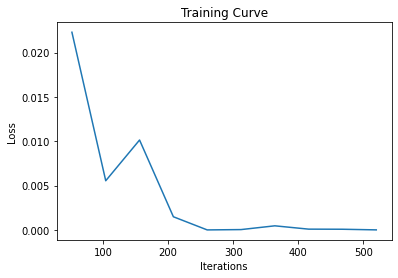

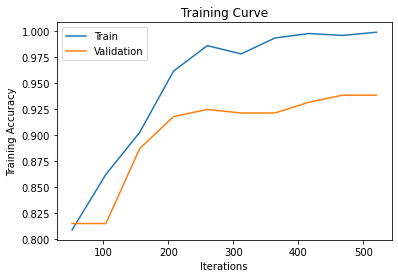

Final Training Accuracy: 0.9987752602571953
Final Validation Accuracy: 0.9383561643835616


In [ ]:
from torchvision.datasets.folder import DatasetFolder

# loading the training dataset
train_features = DatasetFolder(root='/content/drive/MyDrive/alexnet data/train', loader = torch.load, extensions= ('.tensor'))

# loading the validation dataset
val_features = DatasetFolder(root='/content/drive/MyDrive/alexnet data/val', loader = torch.load, extensions= ('.tensor'))

# defining the model
model = CNN_alexnet()
model.cuda()

# training
train(model, train_features, val_features, batch_size= 32, num_epochs = 10, learning_rate = 0.001, ker_increase = False)

**Hyperparameter tuning**



*   Learning rate -  I increased the learning rate to 0.001 from 0.0005 due to having pre-trained features.
*   Batch size - I decreased the batch size to 32 from 50.
*   I increased the number of hidden units to 50.




Changing these three hyperparameters resulted in the best model.



### Part (d) - 2 pt
Report the test accuracy of your best model. How does the test accuracy compare to Part 3(d) without transfer learning?

In [ ]:
model = CNN_alexnet()
model.cuda()
model_path = get_model_name(model.name, batch_size=32, learning_rate=0.001, epoch=7, ker_increase = False)
state = torch.load(model_path)
model.load_state_dict(state)

# Loading testing dataset
test_features = DatasetFolder(root='/content/drive/MyDrive/alexnet data/test', loader = torch.load, extensions= ('.tensor'))

# getting the test accuracy
test_acc = get_accuracy(model, batch_size = 32, data = test_features)
print("Test accuracy: {}".format(test_acc))

Test accuracy: 0.9013605442176871


**Answers:**

The test accuracy of the best model was `0.9013605442176871`. This is much higher than the accuracy of the best model in Part 3(d) without transfer learning.

### 5. Additional Testing [5 pt]
As a final step in testing we will be revisiting the sample images that you had collected and submitted at the start of this lab. These sample images should be untouched and will be used to demonstrate how well your model works at identifying your hand guestures.

Using the best transfer learning model developed in Part 4. Report the test accuracy on your sample images and how it compares to the test accuracy obtained in Part 4(d)? How well did your model do for the different hand guestures? Provide an explanation for why you think your model performed the way it did?

In [ ]:
# transforming the images to tensors of size 224X224
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Loading small dataset
small_data = ImageFolder(root="/content/drive/MyDrive/small dataset", transform=transform)
small_loader =  torch.utils.data.DataLoader(small_data, batch_size=1, shuffle = True)

# defining paths to save the alexnet features
small_path = '/content/drive/MyDrive/alexnet_small_data'

# defining the labels so that I can easily split the data for ImageFolder
letters = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']

# train data
# now need to precompute the features, and save them with their labels
n = 0
for img, label in small_loader:
  # compute the feature
  feature = alexnet.features(img)
  # convert feature to a tensor using code provided
  feature = torch.from_numpy(feature.detach().numpy()).squeeze(0)
  # make the subdirectories
  # Define the name of the new subdirectory
  new_dir_name = letters[label]
  # Define the path to the new subdirectory
  new_dir_path = os.path.join(small_path, new_dir_name)
  if not os.path.exists(new_dir_path):
    os.makedirs(new_dir_path)
  # now I need to put the feature tensor into the subdirectory
  torch.save(feature, os.path.join(new_dir_path, str(n) + '.tensor'))
  n += 1

# loading the small dataset
small_features = DatasetFolder(root='/content/drive/MyDrive/alexnet_small_data', loader = torch.load, extensions= ('.tensor'))

# computing the accuracy on the small dataset
small_acc = get_accuracy(model, batch_size = 32, data = small_features)
print("Accuracy on small sample = {}".format(small_acc))

Accuracy on small sample = 1.0


**Answers:**

The test accuracy on the sample images was `1.0`.

This accuracy is higher than the accuracy on the test data in Part 4(d).

The model predicted every hand gesture in the sample images correctly.

I believe the model performed well because it used AlexNet features. These features are good for small datasets because they were learned on a very large dataset with more than a million images, and thus are robust to variations in input data. Also, they have been finetuned on the model that I wrote in this lab, which improves their effectiveness even more.